# Average photon energy

In this tutorial, you will investigate the average photon energy (APE) of different spectral irradiance distributions. The APE parameter is a useful indicator of the overall shape of the solar spectrum. Higher/lower APE values indicate a blue/red shift in the spectrum and is one of a variety of such characterisation methods that is used in the PV performance literature.

The first step is to import a few Python packages.

In [ ]:
# Install pvlib on Google Colab as this is not a standard package.
!pip install pvlib
!pip install scipy

In [1]:
import pvlib  # library for PV and solar calculations
import pandas as pd  # library for data analysis
import matplotlib.pyplot as plt  # library for plotting
import numpy as np  # library for math and linear algebra
import scipy  # library used for scientific computing

## Step 1: Define parameters

The first step is to define a location and some meteorological parameters that we will use in the next step in order to simulate some spectra.

In [2]:
# Location parameters (south-facing panel at DTU)
latitude = 55.7906
longitude = 12.5251
surface_tilt = 34  # assume a tilt for calculating POA irradiance
surface_azimuth = 180  # south-facing system

# Atmopsheric parameters
surface_pressure = 100700  # at 50 m AMSL, roughly [Pa]
precipitable_water = 0.5  # cm
aerosol_turbidity_500nm = 0.1 # turbidity (AOD) at 500 nm
ozone = 0.31  # atmospheric ozone content atm-cm
ground_albedo = 0.2  # ground surface albedo

## Step 2: Calculate Air Mass (AM)

Claculate and plot the AM for today at different times. To calculate the AM, you need to use the function [``pvlib.atmosphere.get_relative_airmass``](https://pvlib-python.readthedocs.io/en/latest/reference/generated/pvlib.atmosphere.get_relative_airmass.html):

In [3]:
times = pd.date_range('2025-10-21 08:30', freq='h', periods=10, tz='Europe/Copenhagen')

location = pvlib.location.Location(latitude, longitude)
solpos = location.get_solarposition(times)
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

# Write your code here
relative_airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

## Step 3: Plot the Air Mass

<Axes: ylabel='Relative airmass [-]'>

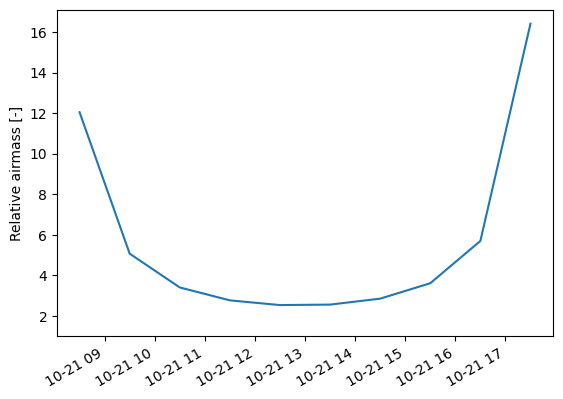

In [5]:
# Write your code here
relative_airmass.plot(ylabel='Relative airmass [-]', ylim=[1, None])

## Step 4: Simulate clearsky spectra

The spectral irradiance distribution can be estimated using the Bird Simple Spectral Model, which is available in pvlib: [``pvlib.spectrum.spectrl2``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.spectrum.spectrl2.html).

In this exercise, we will estimate the spectral irradiance over the course of one clear sky day. 

Note that since you are modeling spectra for more than one set of conditions, you will get a different spectrum for each time step. The output of the spectrl2 function is a dictionary containing 2-D arrays for the spectral irradiance components and a 1-D array of shape (122,) for wavelength. For each of the 2-D arrays, one dimension is for wavelength in nm and one is for irradiance in Wm⁻²nm⁻¹.

In [6]:
spectra_components = pvlib.spectrum.spectrl2(
    apparent_zenith=solpos['apparent_zenith'],
    aoi=aoi,
    surface_tilt=surface_tilt,
    ground_albedo=ground_albedo,
    surface_pressure=surface_pressure,
    relative_airmass=relative_airmass,
    precipitable_water=precipitable_water,
    ozone=ozone,
    aerosol_turbidity_500nm=aerosol_turbidity_500nm,
)

spectra_components.keys() # print the keys of the dictionary

dict_keys(['wavelength', 'dni_extra', 'dhi', 'dni', 'poa_sky_diffuse', 'poa_ground_diffuse', 'poa_direct', 'poa_global'])

## Step 5: Visualize the spectral data

Plot the ``poa_global`` as a function of the ``wavelength`` for the different spectra you have modeled.

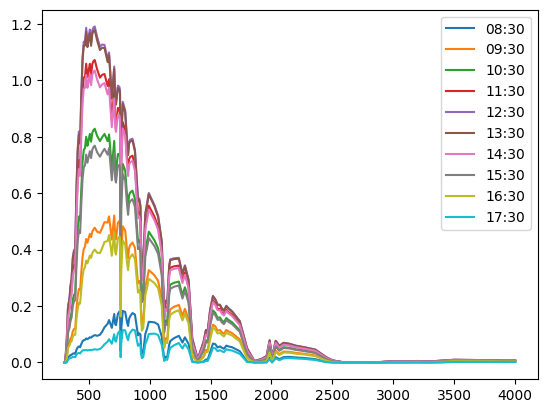

In [12]:
time_labels = times.strftime("%H:%M")  # use this as legend in your plot in order to be easier to identify the different times of the day

# Write your code here
fig, ax = plt.subplots()
ax.plot(spectra_components['wavelength'], spectra_components['poa_global'])
ax.legend(time_labels)
plt.show()

## Step 6: Normalize and plot the spectral irradiance

Given the changing broadband irradiance throughout the day, it is not obvious from the previous plot how the relative distribution of light changes as a function of wavelength. It is also hard to figure out if there is any shift in the spectrum at different times of the day. We can normalize the spectral irradiance curves to visualize this shift in the shape of the spectrum over the course of the day. In this example, we normalize by dividing each spectral irradiance value by the total broadband irradiance.

The total broadband irradiance can be calculated by integrating the entire spectral irradiance distribution (``poa_global``) with respect to ``wavelength``. The integral can be calculated using the [``scipy.integrate.trapezoid``](https://docs.scipy.org/doc/scipy-1.16.2/reference/generated/scipy.integrate.trapezoid.html):

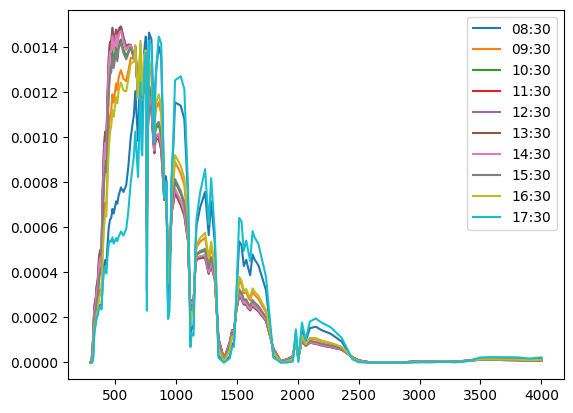

In [15]:
broadband_irradiance = scipy.integrate.trapezoid(spectra_components['poa_global'], spectra_components['wavelength'], axis=0)

spectra_components['poa_global_normalized'] = spectra_components['poa_global'] / broadband_irradiance

# Write your code here
fig, ax = plt.subplots()
ax.plot(spectra_components['wavelength'], spectra_components['poa_global_normalized'])
ax.legend(time_labels)
plt.show()

*What do you notice about the normalized spectra?*

## Step 7: Calculate the average photon energy (APE)

The amount of red and blue shifts that you notice in the figure above can be quantified by calculating the average photon energy (APE). APE can be calculated using [``pvlib.spectrum.average_photon_energy``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.spectrum.average_photon_energy.html#pvlib.spectrum.average_photon_energy). Note that since we have more than one spectral irradiance distribution, we need to use a ``pandas.DataFrame`` as an input ot the above function.

In [19]:
spectra = pd.DataFrame(spectra_components['poa_global']).T  # convert to dataframe and transpose
spectra.index = time_labels  # add time index
spectra.columns = spectra_components['wavelength']  # add wavelength column headers

# Write your code here
ape = pvlib.spectrum.average_photon_energy(spectra)
ape

08:30    1.189932
09:30    1.323497
10:30    1.367120
11:30    1.384883
12:30    1.391442
13:30    1.390768
14:30    1.382485
15:30    1.361346
16:30    1.308210
17:30    1.130262
dtype: float64

*Note that the units of the APE are electronvolts (eV). What do you notice for the different spectra? What values do you expect to get for a red- and a blue-shifted spectrum?*

## Advanced: Investigate the impact of atmospheric parameters

Repeat the previous steps using different atmospheric parameters (i.e., ``precipitable_water``, ``aerosol_turbidity_500nm``, ``ozone``). How do these affect the spectrum?

In [7]:
# Write your code here
